# Knihovna Scikit-learn, přehled užitečných funkcí

V předešlé hodině jsme se vyhýbali programování, jak jen se to dalo. Teď už si ale chceš také sama vše vyzkoušet.
Abys mohla úlohu rozmyšlenou v domácím úkolu naprogramovat, projdeme si nejdůležitější funkce, které budeš potřebovat. Použijeme jednoduchá data [salaries.csv](static/salaries.csv)

Především budeme používat knihovnu [Scikit-learn](https://scikit-learn.org) a samozrejmě také pandas. 
Potřebné věci projdeme na příkladu. 

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

## Načtení a příprava dat 

<table> 
    <tr><td>
        
☑ výběr vstupních proměnných a výstupu

☑ rozdělení na trénovací a testovací data 
        
☑ chybějící hodnoty 

☑ kategorické hodnoty 

☑ přeškálování / normování hodnot  
 </td></tr>
</table> 

Na začátku vždy bude potřeba připravit data. Čištění dat a použití knihovny pandas už bys měla ovládat, 
zaměříme se jen na věci, které jsou specifické pro strojové učení.

Načíst data tedy umíš.

In [2]:
df_salary = pd.read_csv("static/salaries.csv", index_col=0)
df_salary.sample(10)

,rank,discipline,yrs.since.phd,yrs.service,sex,salary
66,AssocProf,B,9,8,Male,100522
115,Prof,A,12,0,Female,105000
17,Prof,B,19,20,Male,101000
142,AssocProf,A,15,10,Male,81500
157,AssocProf,B,12,18,Male,113341
127,Prof,A,28,26,Male,155500
141,AssocProf,A,14,8,Male,100102
31,Prof,B,20,4,Male,132261
19,Prof,A,37,23,Male,124750
168,Prof,B,18,19,Male,130664


Pro přehlednost si data přeložme do češtiny.

In [3]:
df_salary = (
    df_salary
    .rename(columns={"discipline": "disciplina",
             "yrs.since.phd": "delka_praxe",
             "yrs.service": "delka_zamestnani",
             "sex": "pohlavi",
             "salary": "plat"})
    .replace({"Male": "muž",
              "Female": "žena",
              "Prof": "profesor",
              "AssocProf": "docent",
              "AsstProf": "asistent"})
)
df_salary

,rank,disciplina,delka_praxe,delka_zamestnani,pohlavi,plat
1,profesor,B,19,18,muž,139750
2,profesor,B,20,16,muž,173200
3,asistent,B,4,3,muž,79750
4,profesor,B,45,39,muž,115000
5,profesor,B,40,41,muž,141500
...,...,...,...,...,...,...
194,docent,B,19,19,muž,86250
195,docent,B,48,53,muž,90000
196,docent,B,9,7,muž,113600
197,asistent,B,4,4,muž,92700


## Vytvoření trénovací a testovací množiny

Pro predikci použijeme jako příznaky `rank`, `disciplina`, `delka_praxe`, `delka_zamestnani` a `pohlavi`, 
predikovat budeme hodnotu `plat`.  

V teorii strojového učení se vstupy modelu (příznaky, vstupní proměnné) typicky označují písmenem `X` a výstupy písmenem `y`. Řada programátorů toto používá i k označování proměnných v kódu. 
`X` představuje *matici* (neboli tabulku), kde každý řádek odpovídá jednomu datovému vzorku a každý sloupec jednomu příznaku (vstupní proměnné). `y` je vektor, neboli jeden sloupec s odezvou. 

(Na vyzobnutí odezvy se může hodit metoda [pop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pop.html). Její nevýhodou je ale nemožnost opakovaně spouštět buňku.)

In [4]:
y = df_salary["plat"]
X = df_salary.drop(columns=["plat"])

print(X.columns)
print(y.name)

Index(['rank', 'disciplina', 'delka_praxe', 'delka_zamestnani', 'pohlavi'], dtype='object')
plat


In [5]:
X.head()

,rank,disciplina,delka_praxe,delka_zamestnani,pohlavi
1,profesor,B,19,18,muž
2,profesor,B,20,16,muž
3,asistent,B,4,3,muž
4,profesor,B,45,39,muž
5,profesor,B,40,41,muž


In [6]:
y.head()

1    139750
2    173200
3     79750
4    115000
5    141500
Name: plat, dtype: int64

Zbývá data rozdělit na trénovací a testovací, to je třeba udělat co nejdříve, abychom při různých konverzích dat používali jen informace z trénovací množiny a testovací množina byla opravdu jen k evaluaci. K tomu slouží metoda [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train%20test%20split#sklearn.model_selection.train_test_split). 
Data nám rozdělí náhodně na trénovací a testovací sadu. Velikost testovací množiny můžeme specifikovat parametrem `test_size`, jeho defaultní hodnota je `0.25`, t. j. 25%.

In [7]:
from sklearn.model_selection import train_test_split 

#X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
X_train_raw

,rank,disciplina,delka_praxe,delka_zamestnani,pohlavi
181,profesor,B,11,11,muž
106,profesor,A,31,28,muž
155,asistent,B,4,0,muž
29,asistent,B,11,0,muž
173,profesor,B,37,24,muž
...,...,...,...,...,...
196,docent,B,9,7,muž
101,profesor,B,42,25,muž
113,asistent,A,3,1,muž
131,docent,A,11,9,muž


# Kódování vstupů



Pro učení potřebujeme všechny hondoty převést na čísla (`float`). Pokud by data obsahovala chybějící
hodnoty, nejjednodušší řešení je takové řádky zahodit. (Bonus: pokud bys měla data s větším množstvím
chybějících hodnot, podívej se na možnosti [sklearn.impute](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute))

Dále je důležité vypořádat se s kategorickými hodnotami. Sloupce obsahující hodnoty typu Boolean nebo dvě hodnoty (např. muž/žena), lze snadno převést na hodnoty $[0,1]$. 

Pro kategorické proměnné s více možnostmi použijeme tzv. *onehot encoding*. 

Např. sloupec `rank` obsahuje hodnoty `profesor`, `docent` a `asistent`. K zakódování pomocí onehot encoding potřebujeme tři sloupce: 

Původní hodnota | Kód 
--- | --- 
profesor      | 1 0 0
docent  | 0 1 0 
asistent | 0 0 1  


Knihovna Scikitlearn nabízí [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder). 

Při práci s pandas se může hodit i metoda [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html). (Pozn. *dummies* proto, že nám přibudou pomocné proměnné (sloupce), které se označují jako *dummy variables*.) Ale pozor, pokud budeme později potřebovat stejným způsobem zakódovat další data, musí obsahovat stejné kategorie.

In [9]:
pd.get_dummies(X_train_raw).head()

,delka_praxe,delka_zamestnani,rank_asistent,rank_docent,rank_profesor,disciplina_A,disciplina_B,pohlavi_muž,pohlavi_žena
181,11,11,False,False,True,False,True,True,False
106,31,28,False,False,True,True,False,True,False
155,4,0,True,False,False,False,True,True,False
29,11,0,True,False,False,False,True,True,False
173,37,24,False,False,True,False,True,True,False


Naše data zakódujeme pomocí **OneHotEncoder** z knihovny Scikit-learn. 

OneHotEncoder si představ jako krabičku, která má vstupy a výstupy (podobně jako model strojového učení), a vstupy nějak transformuje na výstupy. Každá takováto krabička, která slouží pro přípravu (transformaci) dat, má metody:
+ fit
+ transform
+ fit_transform

Metoda `fit` slouží k inicializaci krabičky, nastavení na daná data. Metoda `transform` pak je samotný běh krabičky, provádí transformaci dat. Metoda `fit_transform` na daných datech krabičku inicializuje a poté data i transformuje.

Rozdělme si sloupečky (vstupní proměnné) podle datových typů.

In [10]:
categorical_columns = ["rank", "disciplina"] 
numerical_columns = ["delka_praxe", "delka_zamestnani"]
boolean_columns = ["pohlavi"]

Kategorické proměnné zakódujme pomocí one-hot kódování.

In [11]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

encoder.fit(X_train_raw[categorical_columns])
# zeptejme se encodéru na jména nových proměnných (sloupečků)
column_names = encoder.get_feature_names_out()

In [12]:
column_names

array(['rank_asistent', 'rank_docent', 'rank_profesor', 'disciplina_A',
       'disciplina_B'], dtype=object)

In [13]:
encoder.transform(X_train_raw[categorical_columns])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 276 stored elements and shape (138, 5)>

Metoda `transform` nám vrátila objekt s řídkou maticí, která se hodí pro data zakódovaná pomocí one-hot kódování. My chceme data i přehledně vidět, proto zde použijeme parametr `sparse_output` a řídký výstup vypneme.

In [14]:
encoder1 = OneHotEncoder(sparse_output=False)
encoder1.fit(X_train_raw[categorical_columns])
encoder1.transform(X_train_raw[categorical_columns])

array([[0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 0.

Umíme tedy vytvořit krabičku, která transformuje data. Zatím jsme jí dávali vybrané sloupce, nyní si pojďme ukázat, jak několik takových krabiček (každou pro jeden typ vstupů) poskládat dohromady do jedné velké krabičky, která umí transformovat celá data (všechny sloupce).

Začneme vytvořením krabičky, která kategorické sloupce zakóduje pomocí one-hot kódování a všechny ostatní nechá v původním stavu.

In [15]:
from sklearn.compose import make_column_transformer

In [16]:
transformer = make_column_transformer(
    # parameter handle_unkown ignore říká, že pokud při transformaci narazíme na neznámou hodnotu,
    # transformace neskončí chybou, ale hodnota se zakóduje pomocí samých 0 
    (OneHotEncoder(sparse_output=False, handle_unknown="ignore"),categorical_columns),
    remainder="passthrough"
)

In [17]:
transformer.fit(X_train_raw)
pd.DataFrame(transformer.transform(X_train_raw))

,0,1,2,3,4,5,6,7
0,0.0,0.0,1.0,0.0,1.0,11,11,muž
1,0.0,0.0,1.0,1.0,0.0,31,28,muž
2,1.0,0.0,0.0,0.0,1.0,4,0,muž
3,1.0,0.0,0.0,0.0,1.0,11,0,muž
4,0.0,0.0,1.0,0.0,1.0,37,24,muž
...,...,...,...,...,...,...,...,...
133,0.0,1.0,0.0,0.0,1.0,9,7,muž
134,0.0,0.0,1.0,0.0,1.0,42,25,muž
135,1.0,0.0,0.0,1.0,0.0,3,1,muž
136,0.0,1.0,0.0,1.0,0.0,11,9,muž


In [18]:
transformer.get_feature_names_out()

array(['onehotencoder__rank_asistent', 'onehotencoder__rank_docent',
       'onehotencoder__rank_profesor', 'onehotencoder__disciplina_A',
       'onehotencoder__disciplina_B', 'remainder__delka_praxe',
       'remainder__delka_zamestnani', 'remainder__pohlavi'], dtype=object)

Teď zbývá zakódovat sloupeček pohlaví, který nabývá dvou hodnot. Samozřejmě můžeme použít i one-hot encoding, ale chceme si ukázat i jiné kódování. Nabízí se použití [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html), který zakóduje hodnoty jako čísla 0 až N-1, kde N je počet tříd. Přidejme tento kodér do našeho velkého transformátoru.

In [19]:
from sklearn.preprocessing import OrdinalEncoder

In [20]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False), categorical_columns),
    (OrdinalEncoder(), boolean_columns),
    remainder="passthrough"
)

In [21]:
X_train_transformed = transformer.fit_transform(X_train_raw)
X_test_transformed = transformer.transform(X_test_raw)

In [22]:
column_names = transformer.get_feature_names_out()
pd.DataFrame(X_test_transformed, columns=column_names).head(10)

,onehotencoder__rank_asistent,onehotencoder__rank_docent,onehotencoder__rank_profesor,onehotencoder__disciplina_A,onehotencoder__disciplina_B,ordinalencoder__pohlavi,remainder__delka_praxe,remainder__delka_zamestnani
0,0.0,0.0,1.0,0.0,1.0,1.0,18.0,18.0
1,0.0,0.0,1.0,0.0,1.0,0.0,40.0,27.0
2,1.0,0.0,0.0,0.0,1.0,0.0,4.0,2.0
3,0.0,0.0,1.0,1.0,0.0,0.0,39.0,36.0
4,0.0,0.0,1.0,0.0,1.0,0.0,40.0,41.0
5,1.0,0.0,0.0,0.0,1.0,0.0,4.0,3.0
6,0.0,1.0,0.0,0.0,1.0,0.0,14.0,5.0
7,0.0,0.0,1.0,0.0,1.0,0.0,20.0,18.0
8,0.0,0.0,1.0,0.0,1.0,0.0,25.0,18.0
9,0.0,0.0,1.0,1.0,0.0,0.0,37.0,37.0


## Škálování

Přeškálování není vždy nutné, ale některým modelům to může pomoci. Řiďte se tedy pravidlem, že rozhodně neuškodí.
Využijeme [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

StandardScaler nám hodnoty přeškáluje, aby zhruba odpovídaly normálnímu rozdělení. Některé algoritmy (na učení) to předpokládají. Pokud bychom neškálovali, mohlo by se stát, že příznak (sloupeček), která má výrazně větší rozptyl než ostatní, je brán jako významnější. 

Nejprve si ukažme jednoduchý příklad. Vygenerujeme si dva sloupečky náhodných bodů, každý jiným způsobem. 

In [23]:
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt
import seaborn as sns 

# vygeneruje 100 náhodných bodů
example = pd.DataFrame({"a": 100+np.random.randn(100), "b": 100*np.random.randn(100)})
example.head(20)

,a,b
0,99.528068,-100.601738
1,101.088951,-121.418861
2,100.064280,115.811087
3,98.922255,79.166269
4,99.284696,62.411982
5,100.679598,62.834551
6,99.269633,-1.224677
7,100.216459,-89.725437
8,100.045572,7.580456
9,99.348400,-67.716171


Podívejme se, jak sloupečky vypadají. Ve sloupci `a` máme hodnoty s malým rozptylem kolem 100 a ve sloupci `b` čísla s velkým rozptylem a průměrem v nule.

In [24]:
example.describe()

,a,b
count,100.000000,100.000000
mean,100.059642,7.032208
std,0.972054,93.675134
min,96.758733,-212.389572
25%,99.394162,-61.883491
50%,100.067041,3.574538
75%,100.698288,64.379513
max,102.143944,218.980293


Data nyní přeškálujeme pomocí `StandardScaler` a podíváme se, jak vypadají původní a přeškálovaná data.

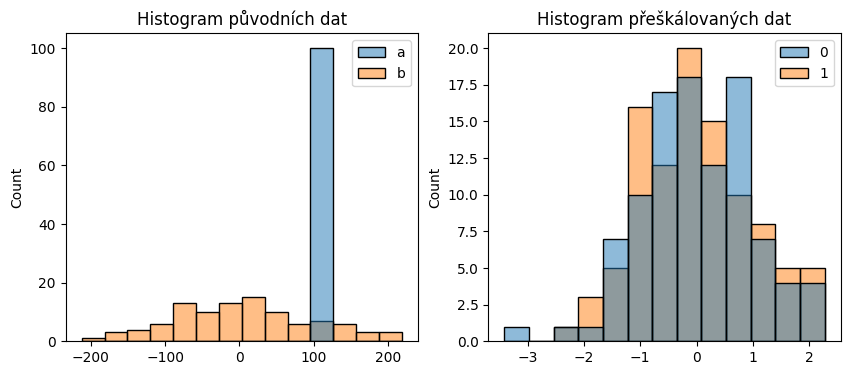

In [25]:
example_scaler = StandardScaler()
transformed_example = example_scaler.fit_transform(example)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
ax1.set_title("Histogram původních dat")
sns.histplot(example, ax=ax1)
ax2.set_title("Histogram přeškálovaných dat")
sns.histplot(transformed_example, ax=ax2);

In [26]:
pd.DataFrame(transformed_example).describe()

,0,1
count,1.000000e+02,1.000000e+02
mean,2.807976e-14,-1.554312e-17
std,1.005038e+00,1.005038e+00
min,-3.412916e+00,-2.354170e+00
25%,-6.880605e-01,-7.393946e-01
50%,7.650264e-03,-3.709724e-02
75%,6.603168e-01,6.152776e-01
max,2.155027e+00,2.273985e+00


In [27]:
pd.DataFrame(transformed_example).head()

,0,1
0,-0.549611,-1.154802
1,1.064235,-1.378148
2,0.004796,1.167085
3,-1.175980,0.773924
4,-0.801241,0.594168


Zpátky k našim datům o platech. Transformaci musíme nastavit (fit) pouze na trénovacích datech, škálovat pak budeme stejným způsobem trénovací i testovací data.

In [28]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_transformed)
X_test = scaler.transform(X_test_transformed)

pd.DataFrame(X_train, columns=column_names).sample(10)

,onehotencoder__rank_asistent,onehotencoder__rank_docent,onehotencoder__rank_profesor,onehotencoder__disciplina_A,onehotencoder__disciplina_B,ordinalencoder__pohlavi,remainder__delka_praxe,remainder__delka_zamestnani
70,1.938716,-0.527046,-1.157144,-0.582929,0.582929,-0.39958,-1.161864,-0.892629
122,-0.515805,-0.527046,0.864196,1.715476,-1.715476,-0.39958,2.977505,3.060720
89,-0.515805,1.897367,-1.157144,-0.582929,0.582929,-0.39958,-0.570525,-0.623082
19,-0.515805,1.897367,-1.157144,-0.582929,0.582929,2.50263,-0.655002,-0.353536
39,-0.515805,-0.527046,0.864196,-0.582929,0.582929,-0.39958,2.217213,2.701325
98,1.938716,-0.527046,-1.157144,-0.582929,0.582929,-0.39958,-1.415294,-1.162175
77,-0.515805,-0.527046,0.864196,-0.582929,0.582929,-0.39958,0.274244,0.544953
110,-0.515805,-0.527046,0.864196,1.715476,-1.715476,-0.39958,0.189767,-0.533233
72,-0.515805,-0.527046,0.864196,-0.582929,0.582929,-0.39958,0.274244,-0.533233
86,-0.515805,-0.527046,0.864196,-0.582929,0.582929,-0.39958,0.950059,0.724650


Máme tedy připraveny dvě krabičky, `transformer` a `scaler`. První data převede na numerické hodnoty, druhá je přeškáluje.

<img src="static/flow.png" width="70%">

## Modely 

Můžeme přejít k samotnému učení. Data máme připravena, nyní chceme za připravené krabičky zapojit model, který bude generovat požadovanou predikci. 

<img src="static/flow2.png" size="80%"/>

Vybereme si model. Přehled modelů najdeš v sekci [Supervised learnig](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
                                                                                                       
                                        
Na regresi můžeš použít:
- [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) 
 
- [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)
     + hyperparametry: 
          * alpha, float, default=1.0 
 
- [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)        
     + hyperparametry:
          * kernel, default rbf, one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
          * C, float, optional (default=1.0)
          
Na klasifikační úlohy (ke kterým se dostaneme v příští hodině) využiješ: 
 
- [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
    
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
  + hyperparametry:
    * n_estimators, integer, optional (default=100)
   
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
  + hyperparametry:
     * C, float, optional (default=1.0)
     * kernelstring, optional (default=’rbf’)
  


Tyto krabičky, modely, mají metody `fit` a `predict`. `fit` slouží pro učení, předáme jí trénovací data a krabička se na nich naučí. Naučenou krabičku pak můžeme používat k predikcím na nových datech pomocí `predict`.

Protože teď jde jen o způsob použití knihovny, vezmeme nejjednodušší lineární regresi):

In [29]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [30]:
model

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Trénování

Model natrénujeme na trénovací množině:

In [31]:
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Predikce 

Natrénovaný model typicky chceme použít k ohodnocení nějakých nových datových vzorků, k tomu máme metodu `predict`. Zavolejme ji jak na trénovací, tak na testovací data.

In [32]:
train_predikce = model.predict(X_train)
test_predikce = model.predict(X_test)

Přidejme predikce vedle vstupního DataFramu a podívejme se na několik testovacích vzorků a jejich predikce:

In [33]:
(
    X_test_raw
    .assign(plat=y_test)
    .assign(predikce=test_predikce)
).sample(15)

,rank,disciplina,delka_praxe,delka_zamestnani,pohlavi,plat,predikce
79,asistent,B,3,1,muž,86100,86251.798641
154,docent,B,12,10,žena,103994,96966.992642
127,profesor,A,28,26,muž,155500,117721.842963
16,profesor,B,12,3,muž,117150,132146.751587
77,profesor,B,17,3,muž,150480,131988.596206
114,profesor,A,37,37,muž,104279,118519.988724
23,profesor,A,34,30,muž,93904,117925.811214
56,docent,B,14,5,muž,83900,98724.925355
58,docent,B,9,8,muž,90215,99178.396767
65,asistent,B,4,3,muž,68404,86417.044919


# Jednoduchý dotaz 

Vyzkoušejte si zadat modelu svůj vlastní jednoduchý dotaz. K tomu můžete využít následující jednořádkový DataFrame.

In [34]:
dotaz = pd.DataFrame({
    "rank": "profesor",
    "disciplina": "B",
    "delka_praxe": 30,
    "delka_zamestnani": 10,
    "pohlavi": "muž",
}, index=[0])
dotaz

,rank,disciplina,delka_praxe,delka_zamestnani,pohlavi
0,profesor,B,30,10,muž


Nyní musíme naše nová data ztransformovat stejně, jako jsme to dělali s trénovacími a testovacími daty:

In [35]:
X_query = scaler.transform(transformer.transform(dotaz))
X_query

array([[-0.51580524, -0.52704628,  0.86419641, -0.58292866,  0.58292866,
        -0.39957961,  0.95005911, -0.44338446]])

In [36]:
print(f"Odhadovaný plat vašeho pracovníka je: {model.predict(X_query)[0]:.2f}")

Odhadovaný plat vašeho pracovníka je: 132266.46


## Evaluace modelu

Můžeme využít funkci `score`, která nám vrátí hodnotu $R^2$ metriky:   

In [37]:
print("R2 na trénovací množině: ", model.score(X_train, y_train))
print("R2 na testovací množině: ", model.score(X_test, y_test))

R2 na trénovací množině:  0.5595836894676703
R2 na testovací množině:  0.44012547896345444


Funkce pro všechny možné metriky najdeš v [sklearn.metrics](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn%20metrics#module-sklearn.metrics).
                                                            (nyní nás zajímají [regresní metriky](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn%20metrics#module-sklearn.metrics))          

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MAE_train = mean_absolute_error(y_train, train_predikce)
MAE_test  = mean_absolute_error(y_test, test_predikce)

MSE_train = mean_squared_error(y_train, train_predikce) 
MSE_test = mean_squared_error(y_test, test_predikce)

R2_train = r2_score(y_train, train_predikce)
R2_test = r2_score(y_test, test_predikce)

print("    Trénovací data  Testovací data")
print(f"MSE {MSE_train:>14.3f}  {MSE_test:>14.3f}")
print(f"MAE {MAE_train:>14.3f}  {MAE_test:>14.3f}")
print(f"R2  {R2_train:>14.3f}  {R2_test:>14.3f}")

    Trénovací data  Testovací data
MSE  371323242.638   418020527.179
MAE      13499.748       15155.533
R2           0.560           0.440


## Porovnání s baseline

Pro jednoduché zjištění, zda se model něco naučil, můžeme použít **baseline** řešení připravené v knihovně Scikit-learn, a jím je [DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor).

In [39]:
from sklearn.dummy import DummyRegressor

baseline = DummyRegressor()
baseline.fit(X_train, y_train)

print("R2 na trénovací množině: ", baseline.score(X_train, y_train))
print("R2 na testovací množině: ", baseline.score(X_test, y_test))

train_pred = baseline.predict(X_train)
test_pred = baseline.predict(X_test)

print("MSE na trénovací množině: ", mean_squared_error(y_train, train_pred))
print("MSE na testovací množině: ", mean_squared_error(y_test, test_pred))

R2 na trénovací množině:  0.0
R2 na testovací množině:  -0.005743396511123988
MSE na trénovací množině:  843118735.0657951
MSE na testovací množině:  750920731.3776834


## Uložení modelu 

Někdy si potřebujeme naučený model uchovat na další použití. Model lze uložit do souboru a zase načíst pomocí `pickle`.
Kujme pikle:

In [40]:
import pickle 

print(model.score(X_test, y_test))

# uložení modelu     
with open("model.pickle", "wb") as soubor:
    pickle.dump(model, soubor)

# načtení modelu
with open("model.pickle", "rb") as soubor:
    staronovy_model = pickle.load(soubor)

staronovy_model.score(X_test, y_test)

0.44012547896345444


0.44012547896345444

### Bonusy:

 - volba vhodného modelu a jeho hyper-parametrů se skrývá pod klíčovým slovem **model selection**. Knihovna Scikit-learn obsahuje různé pomůcky k ulehčení toho výběru. Přesahuje to ale rámec tohoto kurzu, narazíš-li na to toho téma při samostudiu, pročti si [sklear.model_selection](https://scikit-learn.org/stable/modules/classes.html?highlight=model%20selection#module-sklearn.model_selection). 
 
 - v příkladu výše jsme použili různé transformace nad daty a pak teprve tvorbu modelu. Až budeš v těchto věcech zběhlejší, bude se ti hodit propojit tyto věci dohromady. K tomu slouží tzv. [pipeline](https://scikit-learn.org/stable/modules/classes.html?highlight=pipeline#module-sklearn.pipeline).  


In [41]:
from sklearn.pipeline import Pipeline

In [42]:
pipe = Pipeline([
    ("transform", transformer),
    ("scaler", scaler),
    ("model", model)
])
pipe

,steps,"[('transform', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehotencoder', ...), ('ordinalencoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [43]:
pipe.fit(X_train_raw, y_train)

,steps,"[('transform', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehotencoder', ...), ('ordinalencoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [44]:
test_prediction = pipe.predict(X_test_raw) 
X_test_raw.sample(10)

,rank,disciplina,delka_praxe,delka_zamestnani,pohlavi
156,profesor,B,21,21,muž
73,profesor,B,29,19,muž
55,docent,B,12,11,muž
56,docent,B,14,5,muž
12,asistent,B,7,2,muž
157,docent,B,12,18,muž
40,docent,B,9,9,muž
79,asistent,B,3,1,muž
88,asistent,B,2,2,muž
1,profesor,B,19,18,muž


In [45]:
X_test_raw.assign(plat=y_test).assign(predikce=test_predikce).sample(10)

,rank,disciplina,delka_praxe,delka_zamestnani,pohlavi,plat,predikce
13,asistent,B,1,1,muž,77700,86315.060793
12,asistent,B,7,2,muž,79800,86223.713013
170,profesor,B,25,18,muž,181257,133212.127751
157,docent,B,12,18,muž,113341,100067.890308
127,profesor,A,28,26,muž,155500,117721.842963
154,docent,B,12,10,žena,103994,96966.992642
117,profesor,A,30,29,muž,148500,117953.896841
23,profesor,A,34,30,muž,93904,117925.811214
63,profesor,B,33,31,muž,109785,134238.781942
57,profesor,B,23,21,muž,117704,133570.705934
